In [1]:
%matplotlib inline

# Using this codebase
This notebook is a quick guide to how to use the `weavingspace` python codebase to make tiled/woven maps of multivariate data.

## Requirements
The codebase depends on [`geopandas`](https://geopandas.org), so you will need to install that dependency. We use a conda environment for the installation as explained at the [`geopandas` site](https://geopandas.org/en/stable/getting_started/install.html). We have found jupyter notebooks (like this document) to be a useful way to figure out options, and recommend you give those a try too. You can make a conda environment with these two modules and all their dependencies with this recipe:

    conda create -n tiledmaps -c conda-forge python-3.10 geopandas jupyter

We recommend recent versions of all packages.

Once these are installed in your environment, read them in

In [2]:
import geopandas as gpd
import matplotlib.pyplot as pyplot

## Example data
An example dataset we've used a lot in our exploration is [this Index of Multiple Deprivation (IMD) for Tamakai Makaurau Auckland, Aotearoa New Zealand](../data/imd-auckland-2018.gpkg?raw=true). Any multivariate spatial dataset will do. The only real requirement is that it have a unique ID attribute for each row in the data table. Whatever dataset you are planning to make, the first thing to do is to read it in. 

In [3]:
data = gpd.read_file(
    "https://github.com/DOSull/weaving-space/blob/main/data/imd-auckland-2018.gpkg?raw=true")

## The workflow
The basic workflow is

1. Pick a tile
2. Make a tiling
3. Make a map

## 1. Pick a tile
`weavingspace` supports a range of tiles (which we expect will increase in variety over time) both conventional 'tilings' and 'weaves'. Because they are initialised differently, these are represented by different classes, `TileUnit` and `WeaveUnit` respectively, although they share much in common and are both subclasses of a `Tileable` class. Anyway, you'll need to import these.

In [4]:
from tile_units import TileUnit
from weave_units import WeaveUnit

Once imported you can instantiate either easily. The defaults are not necessarily very useful, but it's worth making them just to get an idea of things.

In [5]:
tile_unit = TileUnit(crs = data.crs)
weave_unit = WeaveUnit(crs = data.crs, aspect = 1, strands = "b|c")

Once you have a 'unit' the easiest way to see what' going on is to plot it.

<AxesSubplot:>

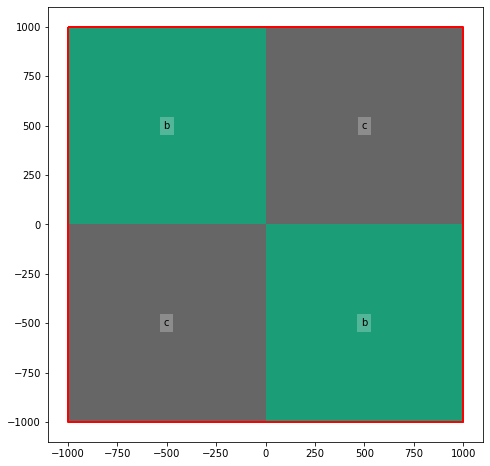

In [6]:
weave_unit.plot(r = 0)

The important attributes of a unit of either type are its *elements* `GeoDataFrame`, and its *tile* `GeoDataFrame`. 

In [7]:
weave_unit.elements, weave_unit.tile

(  element_id                                           geometry
 0          c  POLYGON ((-1000.000 -1000.000, -1000.000 0.000...
 1          c  POLYGON ((0.000 1000.000, 1000.000 1000.000, 1...
 2          b  POLYGON ((0.000 0.000, 1000.000 0.000, 1000.00...
 3          b  POLYGON ((-1000.000 1000.000, 0.000 1000.000, ...,
                                             geometry
 0  POLYGON ((-1000.000 0.000, -1000.000 1000.000,...)

The *elements* are the polygons that will carry different attributes from the data to be mapped. The *tile* is the shape that will be copied and repeated across a region to produce the final map.  There is also a *regularised_tile* which may help you visualize how the tiling will work. It is shown in red outline in the plot. A better example to show the distinctions among these unit attributes is the example below.

<AxesSubplot:>

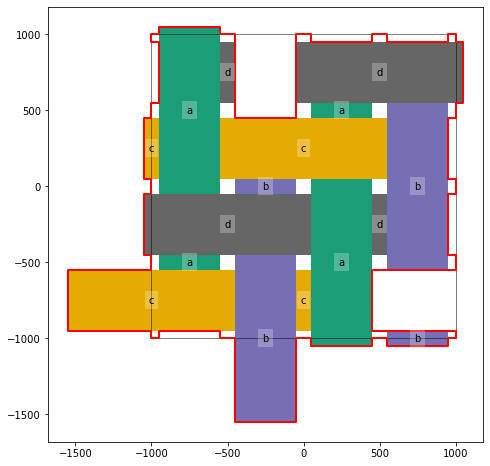

In [8]:
weave_unit = WeaveUnit(weave_type = "twill", spacing = 500, aspect = 0.8, 
                       n = 2, strands = "ab|cd", crs = data.crs)
weave_unit.plot()

Here you can see how a more complex unit will 'jigsawed' together (the red outlinedshape), when it is tiled using the base tile shape (the fine black square). This example also shows some of the options in the `WeaveUnit` case:

+ `spacing` is the spacing of strands in the weave in units of the CRS. Defaults to 1000 (so it will not make sense if coordinates are in latitude-longitude).
+ `aspect` is the proportion of the spacing taken up by the strands. A 500m spacing with aspect 0.8 has 400m wide strands with a gap of 100m between them. Defaults to 1.0.
+ `margin` (not shown here) is an 'inset' distance as a proportion of the spacing---in effect, a negative buffer applied to the weave elements. Defaults to 0.
+ `strands` is a specification for how strands going in the different directions are assigned to colour groups in the final map. the `'|'` separator splits the specification into sequences that apply in each weave axis. In the example there are to be two groups in one direction `'ab'` and two in the other `'cd'`. Defaults to `"a|b"` 
+ `weave_type` specifies a number of possible weave patterns, among them `"plain"`, `"twill"` and `"basket"`. The next cell shows three of these applied to the same general characteristics. Defaults to `"plain"`.
+ `crs` is the CRS of the map that will be made. This has to be specified so we can use various geospatial operations in building the unit. It will be set to 3857 (web mercator) if not specified. 

<AxesSubplot:>

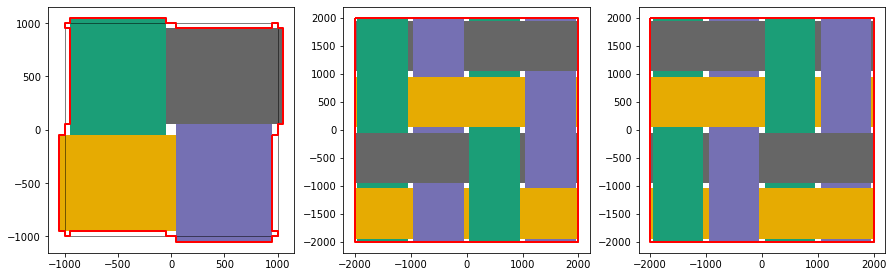

In [9]:
w1 = WeaveUnit(weave_type = "plain", aspect = 0.9, strands = "ab|cd")
w2 = WeaveUnit(weave_type = "twill", aspect = 0.9, strands = "ab|cd")
w3 = WeaveUnit(weave_type = "basket", aspect = 0.9, strands = "ab|cd")

fig = pyplot.figure(figsize = (15, 5))
ax = fig.add_subplot(131)
w1.plot(ax = ax, show_ids = False)
ax = fig.add_subplot(132)
w2.plot(ax = ax, show_ids = False)
ax = fig.add_subplot(133)
w3.plot(ax = ax, show_ids = False)

It is generally easier to see what the weave pattern itself looks like using a simple strand specification.

<AxesSubplot:>

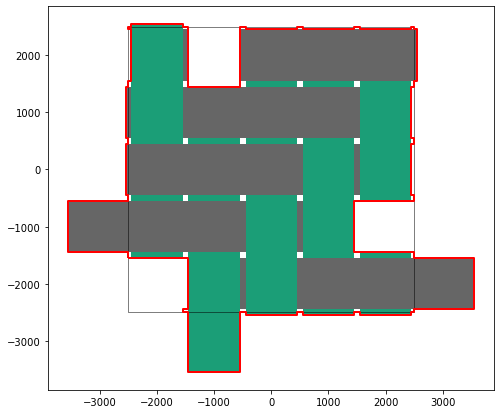

In [10]:
WeaveUnit(
    weave_type = "twill", n = (2, 3), 
    strands = "a|b", aspect = 0.9).plot(show_ids = False)

If you have trouble visualizing the weave, you might find `fit_elements_to_tile()` useful, although it is not recommended to use this for actual tiling, because it may cause problems of inaccurate joins at tile boundaries.

<AxesSubplot:>

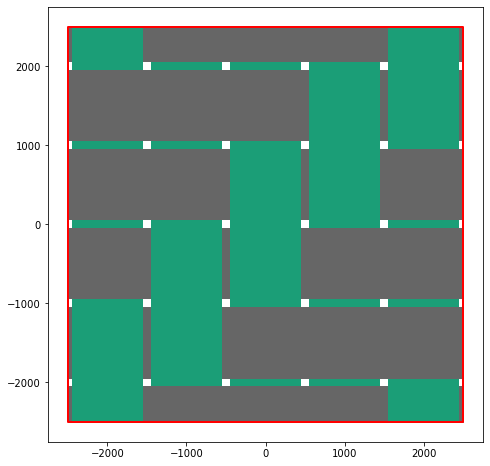

In [11]:
w = WeaveUnit(weave_type = "twill", n = (2, 3), strands = "a|b", aspect = 0.9)
w.fit_elements_to_tile()
w.plot(show_ids = False)

### Seriously... pick a tile!
Many different tiles are available. In addition to the variety that can be generated as `WeaveUnit`s there are a range of possibilities for `TileUnit`s. See the notebook [*All the tiles!*](all-the-tiles.ipynb) for most of the options.

The most important minimal consideration is that the tile unit you choose has enough distinct elements to symbolise the attributes you want to map. With a weave you can pick essentially any number of distinct elements. With the conventional tile units you get the number of distinct elements that the tiling offers.

You could also make your own, since the *elements* and *tile* attributes are `geopandas.GeoDataFrame` objects they could be read in from a geospatial dataset. But that is probably a topic for another notebook.

## 2. Make a tiling
We will work with the object `weave_unit` we made a few cells up the page.

To tile the dataset with this, we do

In [12]:
from tile_map import Tiling

tiling = Tiling(weave_unit, data, id_var = "DZ2018")

Like `Tileable`s this is mostly a collection of `GeoDataFrame`s. The key one is `TilingUnit.tiles` which it's probably easiest to simply take a look at with a web map:

In [13]:
tiling.tiles.explore()

The `Tiling` class tiles a circular region larger than the map area so that we can request a map at any rotation and get a result back quickly. That's the next step.

## 3. Make a tiled map
Again this is simple

<AxesSubplot:>

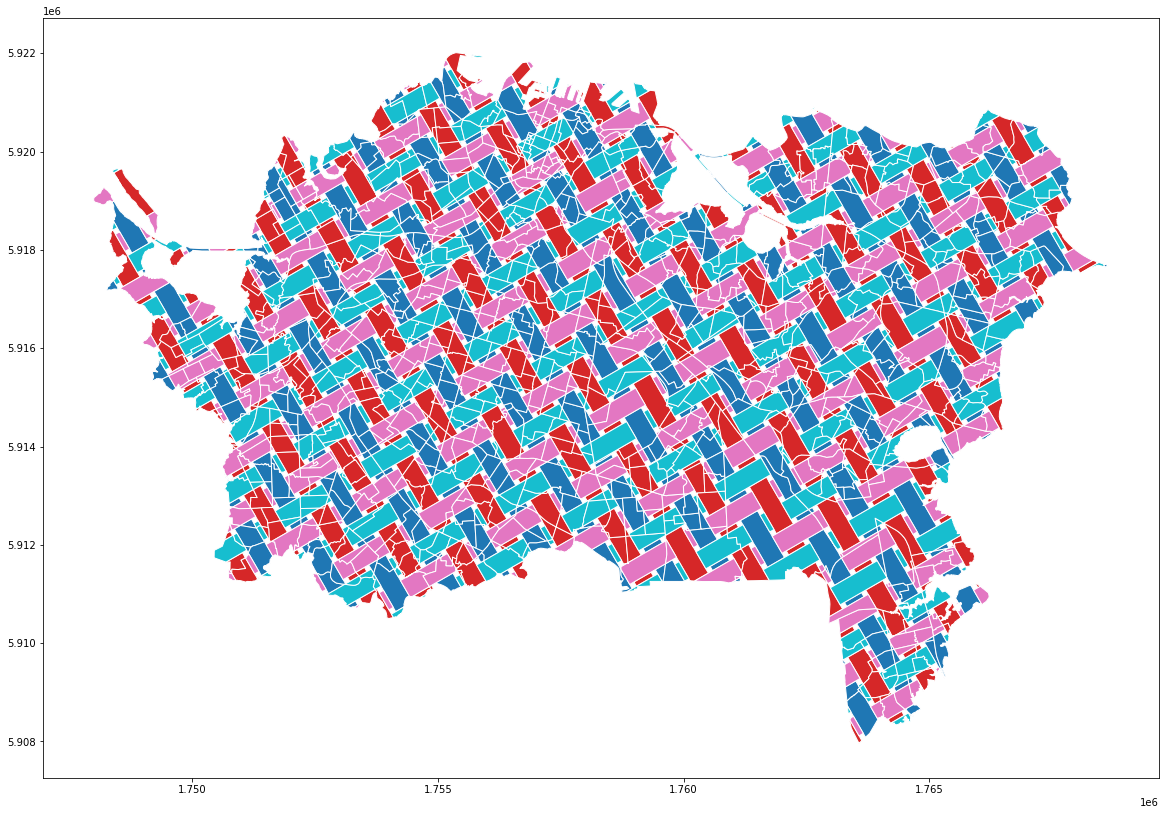

In [14]:
tiled_map = tiling.get_tiled_map(rotation = 30)
tiled_map.plot(column = "element_id", figsize = (20, 14), ec = "w")

In this example we are breaking tiles at the boundaries in the original data. We can have tiling elements over-ride the original boundaries, by setting `prioritise_tiles = True`:

<AxesSubplot:>

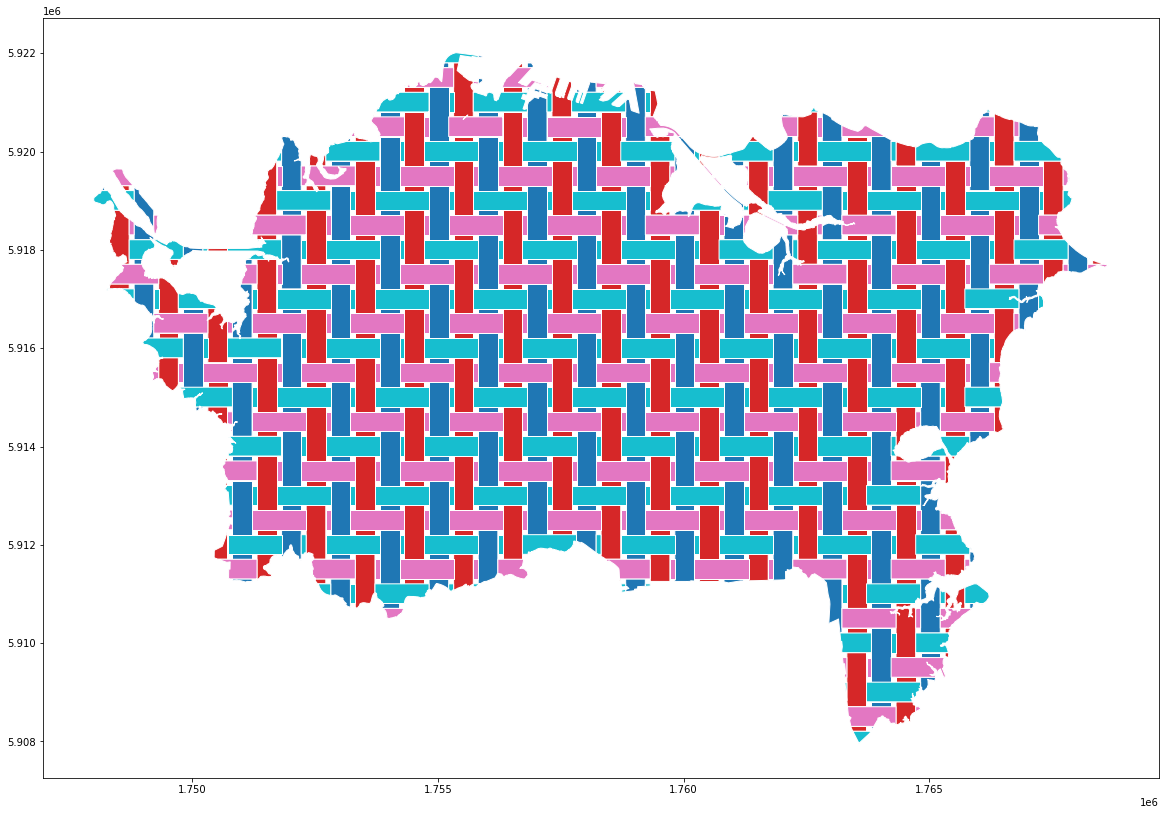

In [15]:
tiled_map = tiling.get_tiled_map(prioritise_tiles = True)
tiled_map.plot(column = "element_id", figsize = (20, 14), ec = "w")

These aren't really the kind of maps we are after (even if they are pretty). Instead we want to associate with each `element_id` in the tiling a different attribute from the dataset. You can do this either by saving the `tiled_map` to a geospatial data format and doing map preparation in a tool of your choice (QGIS, ArcGIS, R, or whatever), or we provide a `plot_map()` method in the `Tiling` class.

(<AxesSubplot:>, <Axes:label='inset_axes'>)

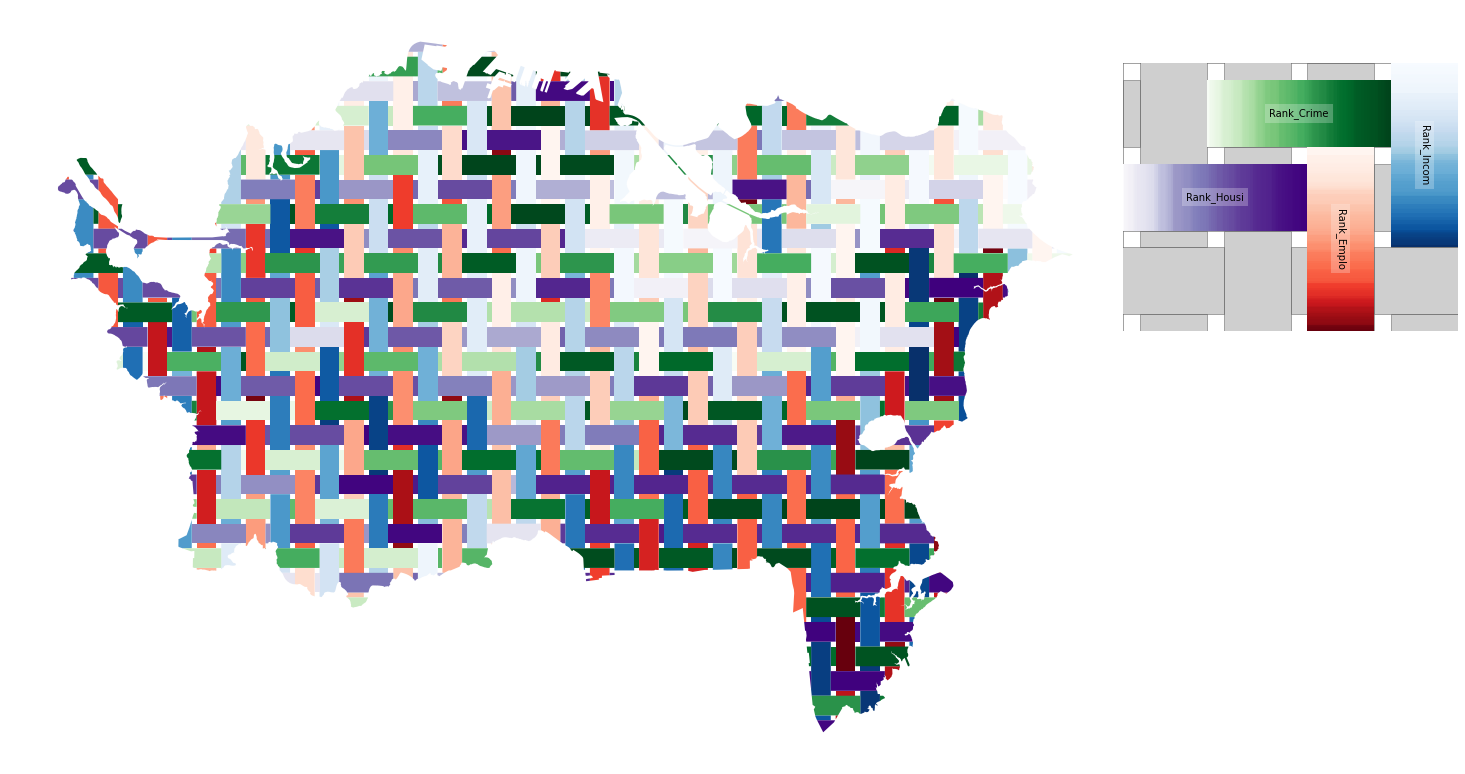

In [16]:
fig = pyplot.figure(figsize = (20, 14))


element_ids = tiled_map.element_id.unique()
variables = dict(zip(element_ids, 
                     ['Rank_Emplo',
                      'Rank_Incom',
                      'Rank_Crime',
                      'Rank_Housi']))
colourmaps = dict(zip(element_ids, 
                      ["Reds", "Blues", "Greens", "Purples"]))

tiling.plot_map(fig, tiled_map, variables, colourmaps)

You can see right away that this is a poor example with the tiling elements much too large for the map. We recommend starting coarse like this until you know what it is you want. But here's a better example all in one cell.

(<AxesSubplot:>, <Axes:label='inset_axes'>)

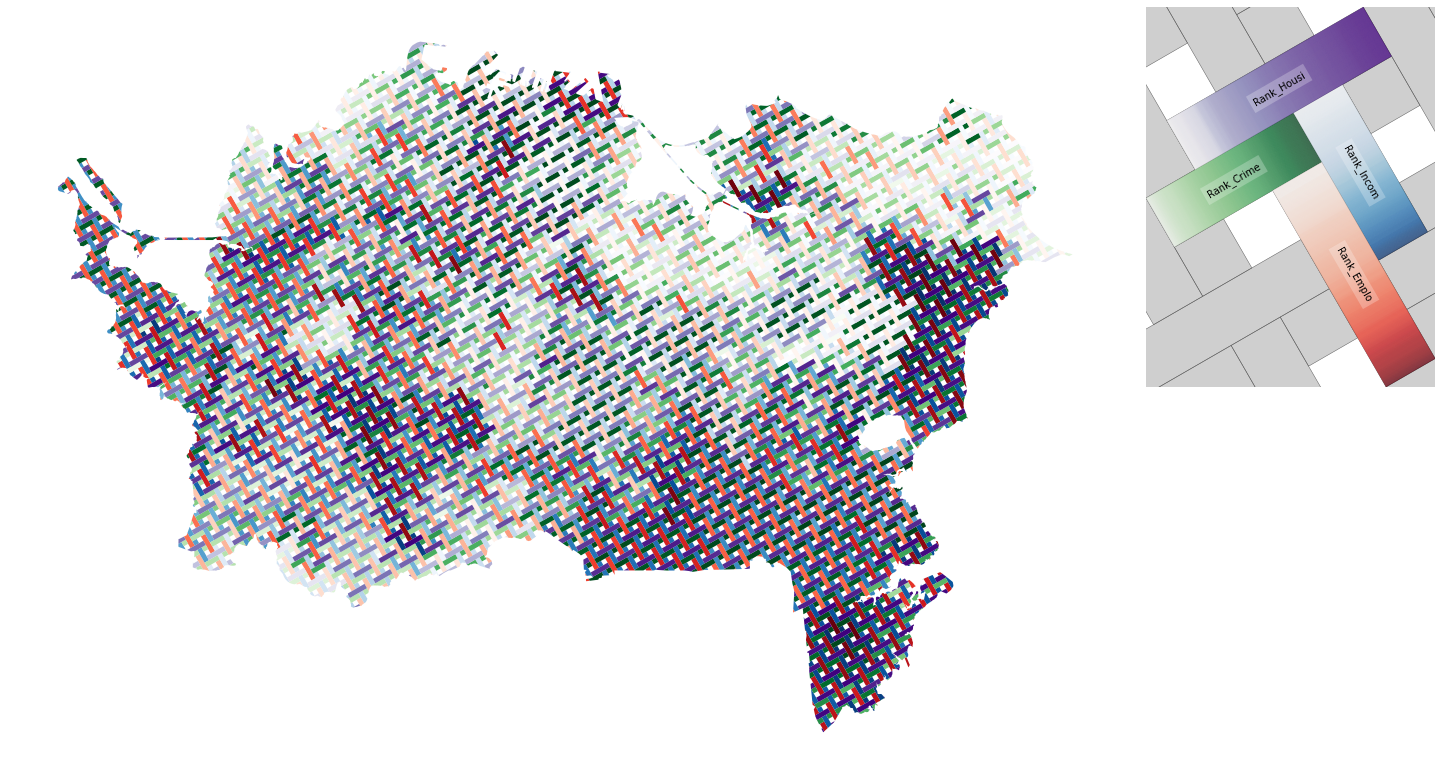

In [17]:
weave_unit = WeaveUnit(spacing = 100, weave_type = "twill", n = 3,
                       strands = "ab-|cd-", crs = data.crs)
tiling = Tiling(weave_unit, data, id_var = "DZ2018")
tiled_map = tiling.get_tiled_map(rotation = 30, prioritise_tiles = True)

fig = pyplot.figure(figsize = (20, 14))
tiling.plot_map(fig, tiled_map, variables, colourmaps)

And here is a more 'conventional' tiling example. We can reuse the `variables` and `colourmaps` dictionaries since the data hasn't changed, we just make a new unit, a `TileUnit` this time, and a new `Tiling` and generate a new tiled map from it.

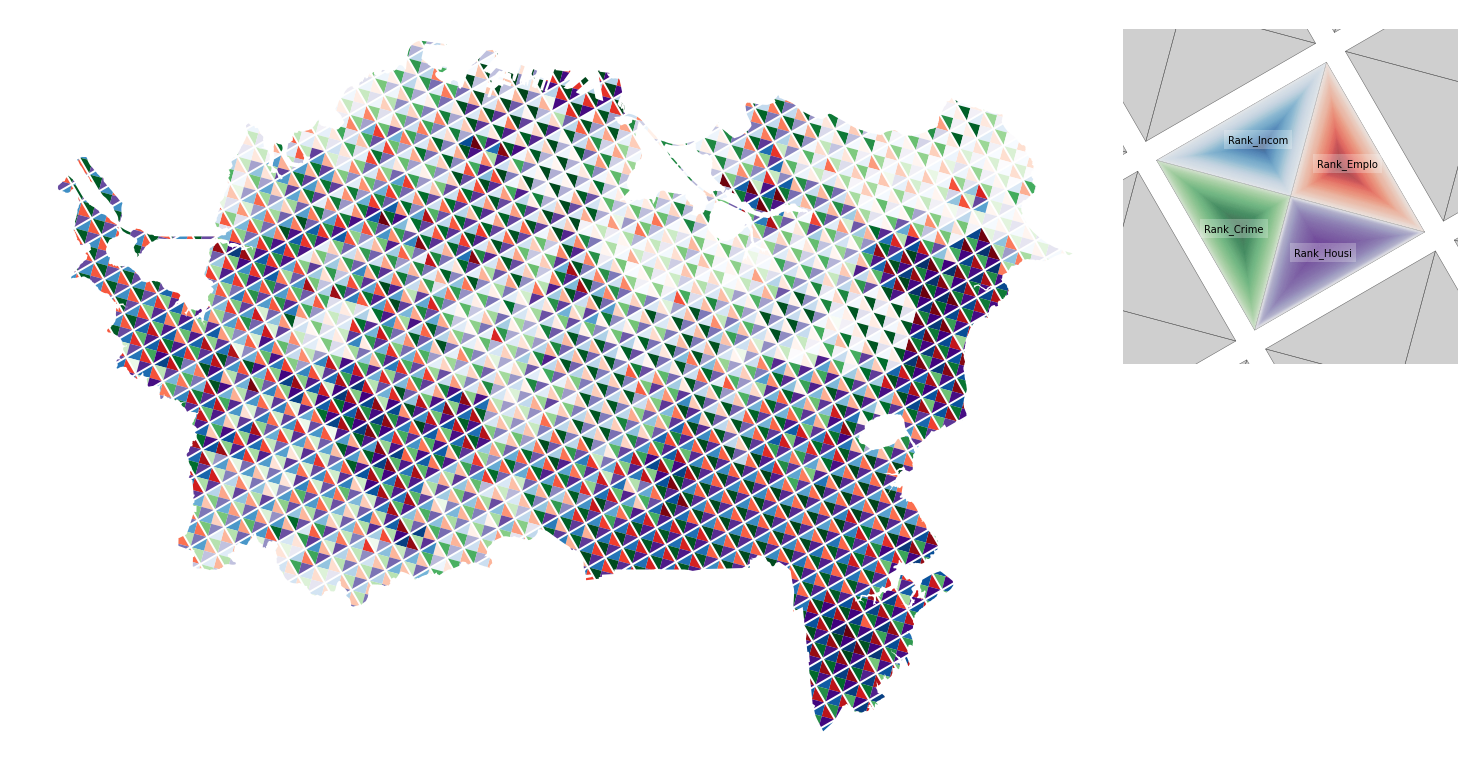

In [18]:
tile_unit = TileUnit(spacing = 400, tiling_type = "laves", code = "4.8.8", 
                     crs = data.crs, margin = 0.1)
tiling = Tiling(tile_unit, data, id_var = "DZ2018")
tiled_map = tiling.get_tiled_map(rotation = 30, prioritise_tiles = True)

fig = pyplot.figure(figsize = (20, 14))
ax = tiling.plot_map(fig, tiled_map, variables, colourmaps, legend_zoom = 0.8)

You might find it easier to make a map in a different tool, in which case export the tiled map produced by `Tiling.get_tiled_map()` to a geospatial data format. However you might want to use the legends our code makes. To make a legend use the code below.

Rank_Emplo  Rank_Incom  Rank_Crime  Rank_Housi element_id  rotation  \
0          149.5       149.5       149.5       149.5          a       -30   
1          149.5       149.5       149.5       149.5          a       -30   
2          149.5       149.5       149.5       149.5          a       -30   
3          149.5       149.5       149.5       149.5          a       -30   
4          149.5       149.5       149.5       149.5          a       -30   
...          ...         ...         ...         ...        ...       ...   
2051      6155.0      6155.0      6155.0      6155.0          d       -30   
2052      6157.0      6157.0      6157.0      6157.0          d       -30   
2053      6173.0      6173.0      6173.0      6173.0          d       -30   
2054      6176.0      6176.0      6176.0      6176.0          d       -30   
2055      6177.0      6177.0      6177.0      6177.0          d       -30   

                                               geometry  
0     POLYGON ((0.012 0.007, 65.888 245.860, 245.865...  
1     POLYGON ((0.028 0.016, 65.892 245.826, 245.837...  
2     POLYGON ((0.048 0.028, 65.898 245.784, 245.804...  
3     POLYGON ((0.071 0.041, 65.904 245.735, 245.765...  
4     POLYGON ((0.097 0.056, 65.911 245.680, 245.721...  
...                                                 ...  
2051  POLYGON ((52.354 -90.680, 54.064 -91.138, 51.8...  
2052                                               None  
2053                                               None  
2054                                               None  
2055                                               None  

[2056 rows x 7 columns]

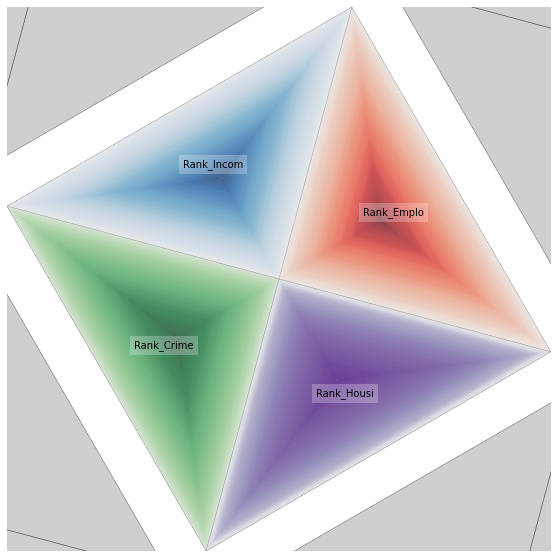

In [19]:
fig = pyplot.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

key_gdf = tile_unit.plot_legend(ax, tiled_map, variables, colourmaps, 
                                map_rotation = 30, return_key_gdf = True)
key_gdf

The central part of the legend is returned as a `GeoDataFrame` by setting `return_key_gdf = True` and can be exported to a geospatial data format for inclusion in a map layout or plotted using `tiling_utils.plot_subsetted_gdf()` and saved to an image format as needed.

<AxesSubplot:>

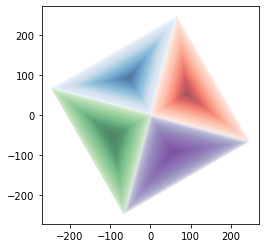

In [20]:
import tiling_utils

ax = pyplot.figure().add_subplot(111)
tiling_utils.plot_subsetted_gdf(ax, key_gdf, variables, colourmaps)